In [1]:
# import all required libraries
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import geopandas as gpd # geospatial data processing library

import requests
import json

from geopy.geocoders import Nominatim # geocoding library

# visualisation libraries
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

print('All libraries imported and ready!')

All libraries imported and ready!


## **Data Collection and Preprocessing**

The data required for this project will be collected from\

a.) **Neighborhood** [Link](https://open.toronto.ca/catalogue/?search=neighbourhood&sort=score%20desc)\
This dataset is available on the Toronto Open Data Portal and is described as -   
'Boundaries of Toronto Neighbourhoods.'\
**Format:**\
i.) .geojson (for boundary)

b.) **Neighborhood Profiles** [Link](https://open.toronto.ca/dataset/neighbourhood-profiles/)\
This dataset is available on the Toronto Open Data Portal and is described as -  
'The Neighbourhood Profiles provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighbourhood. The data is based on tabulations of 2016 Census of Population data from Statistics Canada.'

c.) **Neighbourhood Crime Rates (Boundary File)** [Link](http://data.torontopolice.on.ca/datasets/neighbourhood-crime-rates-boundary-file-)\
This dataset is available on the Toronto Police Service - Public Safety Data Portal and is described as -    
'Toronto Neighbourhoods Boundary File includes 2014-2018 Crime Data by Neighbourhood. Counts are available for Assault, Auto Theft, Break and Enter, Robbery, Theft Over and Homicide. Data also includes four year averages and crime rates per 100,000 people by neighbourhood based on 2016 Census Population.'

d.) **Foursquare API** [Link](https://developer.foursquare.com/docs/places-api/)\
Foursquare is a technology company that has built a huge location dataset through crowd-sourcing. Fousquare's data is currently used by companies like Uber, Snapchat, Twitter and Apple Maps.\
For this project, Foursquare API will be used to collect data on:\
i.) Cannabis Retail Stores in Toronto\
ii.) Neighborhood Venues (100 locations within a radius of 1km from the coordinates of every neighborhood)

### **a.) Neighborhood** [Link](https://open.toronto.ca/catalogue/?search=neighbourhood&sort=score%20desc)

In [2]:
# load the data using geopandas
tor_gdf = gpd.read_file('/Users/parth/Desktop/Jupyter_Labs/Data/Neighbourhoods.geojson')

In [3]:
# first filter the shape dataframe(tor_gdf)
map_df = tor_gdf[['AREA_NAME','AREA_SHORT_CODE', 'LATITUDE', 'LONGITUDE','geometry']]
map_df = map_df.rename(columns={'AREA_SHORT_CODE':'neighborhood_num', 'AREA_NAME':'neighborhood',
                               'LONGITUDE': 'longitude','LATITUDE':'latitude'})

In [4]:
# remove the neighborhood number from the neighborhoods as we already have a column with neighborhood num
map_df['neighborhood'] = map_df['neighborhood'].replace({'\(': '', '\)': '', '\d':'' , '\d\d':'','\d\d\d':''},
                                                          regex=True).str.strip()

In [5]:
map_df.shape

(140, 5)

In [6]:
map_df.head()

neighborhood  neighborhood_num   latitude  longitude  \
0                 Wychwood                94  43.676919 -79.425515   
1           Yonge-Eglinton               100  43.704689 -79.403590   
2           Yonge-St.Clair                97  43.687859 -79.397871   
3  York University Heights                27  43.765736 -79.488883   
4       Yorkdale-Glen Park                31  43.714672 -79.457108   

                                            geometry  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

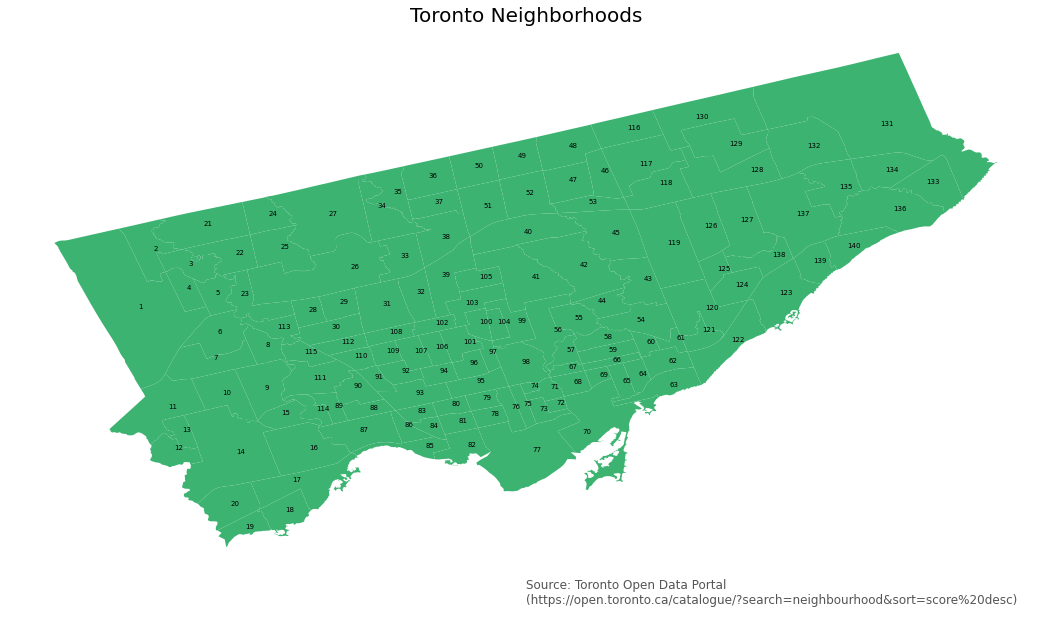

In [7]:
# visualise the map of Toronto
map_df.plot(figsize=(20,10), color='mediumseagreen')
# annotate
plt.annotate('Source: Toronto Open Data Portal\n(https://open.toronto.ca/catalogue/?search=neighbourhood&sort=score%20desc)', 
            xy=(0.5, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# add Labels
map_df['coords'] = map_df['geometry'].apply(lambda x: x.representative_point().coords[:])
map_df['coords'] = [coords[0] for coords in map_df['coords']]

for idx, row in map_df.iterrows():
    plt.annotate(s=row['neighborhood_num'], xy=row['coords'], size=7)
plt.title('Toronto Neighborhoods', fontdict={'fontsize':20, 'fontweight':10}, color='black')
plt.axis('off')
plt.savefig('Toronto Neighborhoods.png')
plt.show()

### **b.) Neighborhood Profiles** [Link](https://open.toronto.ca/dataset/neighbourhood-profiles/)

As per the requirements, the following records will be needed:

Population and Age census records
- Neighborhood Number [idx 0]
- Population,2016 [idx 2]
- Density per square kilometre [idx 7]
- Male and Female (age 0 to 100 and over)  [idx 15 to 57]

Martial status census records
- Maritial status for population age 15 and over [idx 75]
- Married [idx 77]
- Never Married [idx 80]
- Couples without children [idx 89]
- Couple census families in private households [idx 97]
- Couples with children [idx 98]

Income census records
- Total income, Average amount [idx 2272]

*idx = index number

In [8]:
# load the neighborhoods profiles dataset that contains the census data
census_df = pd.read_csv('~/Desktop/Jupyter_Labs/Data/neighbourhood_profiles_2016.csv')

In [9]:
# check the size of the dataset
print ('There are {} rows and {} columns in the dataframe.'.format(census_df.shape[0],census_df.shape[1]))
census_df.head()

There are 2383 rows and 146 columns in the dataframe.


_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
3    4                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   

                      Data Source               Characteristic  \
0                 City of Toronto         Neighbourhood Number   
1                 City of Toronto         TSNS2020 Designation   
2  Census Profile 98-316-X2016001             Population, 2016   
3  Census Profile 98-316-X2016001             Population, 2011   
4  Census Profile 98-316-X2016001  Population Change 2011-2016   

  City of Toronto Agincourt North Agincourt South-Malvern West  \
0             NaN             129                          128   
1             NaN  No Designation               No Designation   
2       2,731,571          29,113                       23,757   
3       2,615,060          30,279                       21,988   
4           4.50%          -3.90%                        8.00%   

        Alderwood           Annex  ... Willowdale West  \
0              20              95  ...              37   
1  No Designation  No Designation  ...  No Designation   
2          12,054          30,526  ...          16,936   
3          11,904          29,177  ...          15,004   
4           1.30%           4.60%  ...          12.90%   

  Willowridge-Martingrove-Richview  Woburn Woodbine Corridor Woodbine-Lumsden  \
0                                7     137                64               60   
1                   No Designation     NIA    No Designation   No Designation   
2                           22,156  53,485            12,541            7,865   
3                           21,343  53,350            11,703            7,826   
4                            3.80%   0.30%             7.20%            0.50%   

         Wychwood  Yonge-Eglinton  Yonge-St.Clair York University Heights  \
0              94             100              97                      27   
1  No Designation  No Designation  No Designation                     NIA   
2          14,349          11,817          12,528                  27,593   
3          13,986          10,578          11,652                  27,713   
4           2.60%          11.70%           7.50%                  -0.40%   

       Yorkdale-Glen Park  
0                      31  
1  Emerging Neighbourhood  
2                  14,804  
3                  14,687  
4                   0.80%  

[5 rows x 146 columns]

In [10]:
# get all the records in one dataframe
df = census_df.iloc[[0,2,7]]
df = df.append(census_df.iloc[15:57])
df = df.append(census_df.iloc[[75,77,80,89,97,98,2272]])

In [11]:
# check the shape of the new dataframe
df.shape

(52, 146)

In [12]:
df.columns

Index(['_id', 'Category', 'Topic', 'Data Source', 'Characteristic',
       'City of Toronto', 'Agincourt North', 'Agincourt South-Malvern West',
       'Alderwood', 'Annex',
       ...
       'Willowdale West', 'Willowridge-Martingrove-Richview', 'Woburn',
       'Woodbine Corridor', 'Woodbine-Lumsden', 'Wychwood', 'Yonge-Eglinton',
       'Yonge-St.Clair', 'York University Heights', 'Yorkdale-Glen Park'],
      dtype='object', length=146)

In [13]:
# drop unnecessary columns
df = df.drop(['_id','Category','Topic','Data Source'], axis=1)

In [14]:
# transpose the dataframe so neighborhoods is a column
df.set_index('Characteristic',inplace=True)
df = df.T.reset_index()
df.rename_axis('',axis='columns',inplace=True)
df.rename(columns={'index': 'Neighborhood'}, inplace=True)
df.shape

(141, 53)

In [15]:
col_list = list(df.columns[2:]) # columns after Neighborhood and Neighborhood Number
df[col_list] = df[col_list].replace({'\$': '', ',': ''}, regex=True) # replace values with ',' or '$' with ''

# convert numeric data to type int
df[col_list] = df[col_list].astype(float)

# remove any resulting whitespace
df.columns = df.columns.str.strip()

# check if all columns are in the right format
df.dtypes


Neighborhood                                                 object
Neighbourhood Number                                         object
Population, 2016                                            float64
Population density per square kilometre                     float64
Male: 0 to 04 years                                         float64
Male: 05 to 09 years                                        float64
Male: 10 to 14 years                                        float64
Male: 15 to 19 years                                        float64
Male: 20 to 24 years                                        float64
Male: 25 to 29 years                                        float64
Male: 30 to 34 years                                        float64
Male: 35 to 39 years                                        float64
Male: 40 to 44 years                                        float64
Male: 45 to 49 years                                        float64
Male: 50 to 54 years                           

In [16]:
# drop the City of Toronto row
df = df.drop([0], axis=0)

#### **Population and Age census records**

In [17]:
# create a new dataframe from age records
age_df = pd.DataFrame(columns=['neighborhood','20-39yrs','% 20-39yrs','40-64yrs','% 40-64yrs'])

In [18]:
# aggregate data for male and female by age 
# create a list with columns from df
# col_list1 (Target group 20 to 39yrs)
#col_list2 (Target group 40 to 64yrs)
col_list1 = ['Male: 20 to 24 years','Male: 25 to 29 years','Male: 30 to 34 years','Male: 35 to 39 years',
            'Female: 20 to 24 years','Female: 25 to 29 years','Female: 30 to 34 years','Female: 35 to 39 years']

col_list2 = ['Male: 40 to 44 years','Male: 45 to 49 years','Male: 50 to 54 years','Male: 55 to 59 years', 'Male: 60 to 64 years',
            'Female: 40 to 44 years','Female: 45 to 49 years','Female: 50 to 54 years','Female: 55 to 59 years', 'Female: 60 to 64 years']

In [19]:
# fill values in age_df
age_df['neighborhood'] = df['Neighborhood']
age_df['20-39yrs'] = (df[col_list1]).sum(axis=1) # Total population in target group 1
age_df['% 20-39yrs'] = round((age_df['20-39yrs'] / df['Population, 2016']),4)
age_df['40-64yrs'] = (df[col_list2]).sum(axis=1) # Total population target group 2
age_df['% 40-64yrs'] = round((age_df['40-64yrs'] / df['Population, 2016']),4)

In [20]:
age_df.head()

neighborhood  20-39yrs  % 20-39yrs  40-64yrs  % 40-64yrs
1               Agincourt North    7235.0      0.2485   10290.0      0.3535
2  Agincourt South-Malvern West    6910.0      0.2909    8215.0      0.3458
3                     Alderwood    3115.0      0.2584    4580.0      0.3800
4                         Annex   12460.0      0.4082    8775.0      0.2875
5             Banbury-Don Mills    5965.0      0.2154    9755.0      0.3522

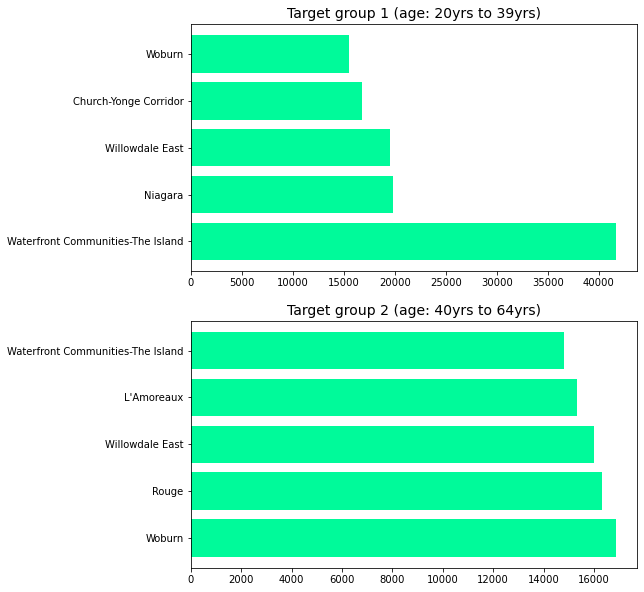

In [21]:
# visualise the top 5 neighborhoods for each of our target group
t_group1 = age_df.sort_values('20-39yrs', ascending=False).head(5)
t_group2 = age_df.sort_values('40-64yrs', ascending=False).head(5)

fig = plt.figure(figsize=(8,10))
ax1,ax2 = fig.subplots(2,1)

ax1.barh(t_group1['neighborhood'], t_group1['20-39yrs'], color='mediumspringgreen',align='center')
ax1.set_title('Target group 1 (age: 20yrs to 39yrs)', size=14)
ax1.tick_params(axis='y', labelsize=10)

ax2.barh(t_group2['neighborhood'], t_group2['40-64yrs'], color='mediumspringgreen',align='center')
ax2.set_title('Target group 2 (age: 40yrs to 64yrs)', size=14)
ax2.tick_params(axis='y', labelsize=10)
fig.savefig('Neighborhoods by Target group.png')

In [22]:
age_df = age_df.drop(['20-39yrs','40-64yrs'], axis=1)

In [23]:
age = age_df.copy()

#### **Maritial status census records**

In [24]:
# create a new df with the required columns
mar_df = pd.DataFrame(columns=['neighborhood','% never_married', '% couples_without_children'])

In [25]:
# fill the dataframe
mar_df['neighborhood'] = df['Neighborhood']
mar_df['% never_married'] = round((df['Never married'] / df['Marital status for the population aged 15 years and over']),4)
mar_df['% couples_without_children'] = round((df['Couples without children'] / 
                                                df['Couple census families in private households']),4)

In [26]:
mar_df.head()

neighborhood  % never_married  % couples_without_children
1               Agincourt North           0.2910                      0.3720
2  Agincourt South-Malvern West           0.3192                      0.3968
3                     Alderwood           0.2922                      0.4167
4                         Annex           0.4283                      0.6592
5             Banbury-Don Mills           0.2666                      0.4744

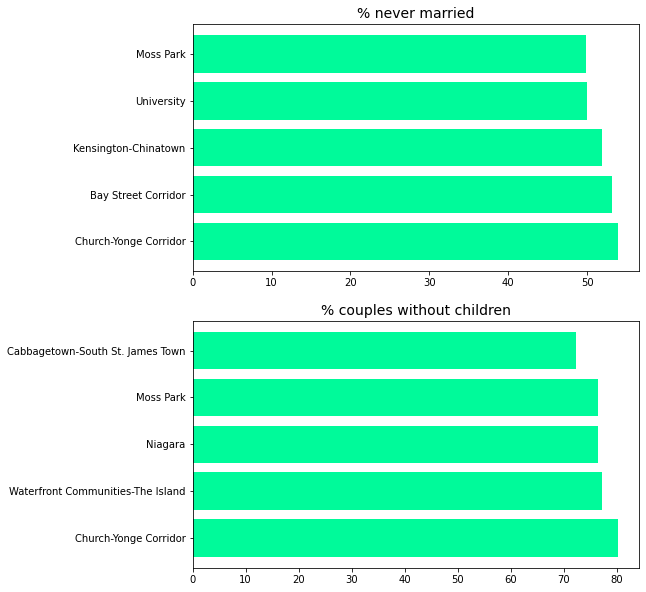

In [27]:
# visaulise the top 5 neighborhoods
Nm_df = mar_df.sort_values('% never_married', ascending=False).head(5)
Wc_df = mar_df.sort_values('% couples_without_children', ascending=False).head(5)

fig = plt.figure(figsize=(8,10))
ax1,ax2 = fig.subplots(2,1)

ax1.barh(Nm_df['neighborhood'], (Nm_df['% never_married']*100), color='mediumspringgreen')
ax1.set_title('% never married', size=14)
ax1.tick_params(axis='y', labelsize=10)

ax2.barh(Wc_df['neighborhood'], (Wc_df['% couples_without_children']*100), color='mediumspringgreen')
ax2.set_title('% couples without children', size=14)
ax2.tick_params(axis='y', labelsize=10)

fig.savefig('Neighborhoods by Married %')

In [28]:
# assign a new variable for mar_df for convenience
marriage = mar_df.copy()

#### **Income census records**

In [29]:
# create a new dataframe for the income data
income_df = pd.DataFrame(columns=['neighborhood', 'average_income'])

In [30]:
income_df['neighborhood'] = df['Neighborhood']
income_df['average_income'] = df['Total income: Average amount ($)']

In [31]:
income_df.head()

neighborhood  average_income
1               Agincourt North         30414.0
2  Agincourt South-Malvern West         31825.0
3                     Alderwood         47709.0
4                         Annex        112766.0
5             Banbury-Don Mills         67757.0

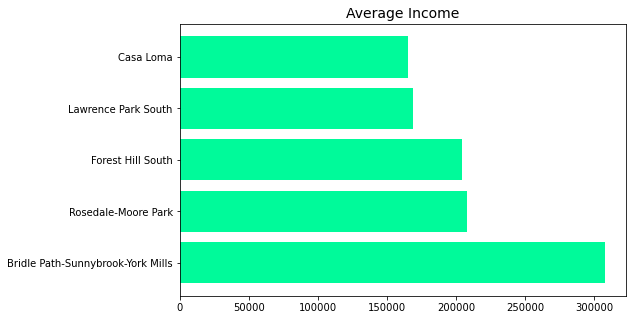

In [32]:
# visualise the top 5 neighborhoods by average income

inc_df = income_df.sort_values('average_income',ascending=False).head(5)

fig = plt.figure(figsize= (8,5))

plt.barh(inc_df['neighborhood'], inc_df['average_income'], color='mediumspringgreen')
plt.title('Average Income', size=14)
plt.tick_params(axis='y', labelsize=10)

fig.savefig('Income by Neighborhood')

In [33]:
# create a new dataframe and merge the 3 df that will be used for the decision matrix
dm_df = pd.DataFrame()
dm_df[['neighborhood','neighborhood_num','population','population_density']] = df.iloc[:,0:4] # first columns of the original df

In [34]:
dm_df = dm_df.merge(age, on='neighborhood', how='outer')
dm_df = dm_df.merge(marriage, on='neighborhood', how='outer')
dm_df = dm_df.merge(income_df, on='neighborhood', how='outer')

In [35]:
dm_df.head()

neighborhood neighborhood_num  population  \
0               Agincourt North              129     29113.0   
1  Agincourt South-Malvern West              128     23757.0   
2                     Alderwood               20     12054.0   
3                         Annex               95     30526.0   
4             Banbury-Don Mills               42     27695.0   

   population_density  % 20-39yrs  % 40-64yrs  % never_married  \
0              3929.0      0.2485      0.3535           0.2910   
1              3034.0      0.2909      0.3458           0.3192   
2              2435.0      0.2584      0.3800           0.2922   
3             10863.0      0.4082      0.2875           0.4283   
4              2775.0      0.2154      0.3522           0.2666   

   % couples_without_children  average_income  
0                      0.3720         30414.0  
1                      0.3968         31825.0  
2                      0.4167         47709.0  
3                      0.6592        112766.0  
4                      0.4744         67757.0

### **c.) Neighbourhood Crime Rates (Boundary File)** [Link](http://data.torontopolice.on.ca/datasets/neighbourhood-crime-rates-boundary-file-)

In [36]:
# using pandas
crimes_df = gpd.read_file('/Users/parth/Desktop/Jupyter_Labs/Data/Neighbourhood_Crime_Rates_(Boundary_File)_.csv')

In [37]:
crimes_df.columns

Index(['OBJECTID', 'Neighbourhood', 'Hood_ID', 'Population', 'Assault_2014',
       'Assault_2015', 'Assault_2016', 'Assault_2017', 'Assault_2018',
       'Assault_2019', 'Assault_AVG', 'Assault_CHG', 'Assault_Rate_2019',
       'AutoTheft_2014', 'AutoTheft_2015', 'AutoTheft_2016', 'AutoTheft_2017',
       'AutoTheft_2018', 'AutoTheft_2019', 'AutoTheft_AVG', 'AutoTheft_CHG',
       'AutoTheft_Rate_2019', 'BreakandEnter_2014', 'BreakandEnter_2015',
       'BreakandEnter_2016', 'BreakandEnter_2017', 'BreakandEnter_2018',
       'BreakandEnter_2019', 'BreakandEnter_AVG', 'BreakandEnter_CHG',
       'BreakandEnter_Rate_2019', 'Homicide_2014', 'Homicide_2015',
       'Homicide_2016', 'Homicide_2017', 'Homicide_2018', 'Homicide_2019',
       'Homicide_AVG', 'Homicide_CHG', 'Homicide_Rate_2019', 'Robbery_2014',
       'Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018',
       'Robbery_2019', 'Robbery_AVG', 'Robbery_CHG', 'Robbery_Rate_2019',
       'TheftOver_2014', 'TheftOver_201

In [38]:
# create a list of required columns to filter the dataframe
crime_cols = ['Neighbourhood','Assault_Rate_2019','AutoTheft_Rate_2019','BreakandEnter_Rate_2019','Homicide_Rate_2019',
            'Robbery_Rate_2019','TheftOver_Rate_2019']

crimes_df = crimes_df[crime_cols]

In [39]:
# simpify the column names
crimes_df.columns = ['neighborhood','assault','autotheft','break_and_enter','homicide','robbery','theftover']

In [40]:
crimes_df.head() 

neighborhood assault autotheft break_and_enter homicide robbery  \
0           Yonge-St.Clair   295.3      47.9           223.5        0    31.9   
1  York University Heights  1340.9     521.9           391.4        0   286.3   
2         Lansing-Westgate   445.4       198           241.3        0    68.1   
3       Yorkdale-Glen Park  1411.8     412.1           567.4      6.8   283.7   
4      Stonegate-Queensway   327.3     135.7           255.5        0    87.8   

  theftover  
0      47.9  
1     101.5  
2      68.1  
3     195.9  
4        16

#### **Calculating the crime rate**
By assigning weights to each attribute in the dataframe, calculate the figure of merit score which will be the crime rate index used in analysis

#### Weightage criteria based on relevance to store owner:

1. assualt - 0.1
2. autotheft - 0.15
3. break_and_enter - 0.2
4. homicide - 0.1
5. robbery - 0.2
6. theftover - 0.25

In [41]:
# multiply columns by their weights to get the weighted matrix
crimes_df['assault_rate'] = crimes_df['assault'].astype(float) * 0.1
crimes_df['autotheft_rate'] = crimes_df['autotheft'].astype(float) * 0.15
crimes_df['break_and_enter_rate'] = crimes_df['break_and_enter'].astype(float) * 0.2
crimes_df['homicide_rate'] = crimes_df['homicide'].astype(float) * 0.1
crimes_df['robbery_rate'] = crimes_df['robbery'].astype(float) * 0.2
crimes_df['theftover_rate'] = crimes_df['theftover'].astype(float) * 0.25

In [42]:
# add the columns to get the crime rate
crimes_df['crime_rate'] = crimes_df.sum(axis=1)

In [43]:
# drop all columns except neighborhood and crimerate
crimes_df = crimes_df[['neighborhood', 'crime_rate']]

In [44]:
crimes_df

neighborhood  crime_rate
0             Yonge-St.Clair      99.770
1    York University Heights     373.290
2           Lansing-Westgate     153.145
3         Yorkdale-Glen Park     422.870
4        Stonegate-Queensway     125.745
..                       ...         ...
135                 Milliken     229.400
136            Pleasant View      91.040
137                 Wychwood     137.630
138       Leaside-Bennington     112.030
139     Briar Hill-Belgravia     196.400

[140 rows x 2 columns]

In [45]:
crimes_df['neighborhood'].unique()

array(['Yonge-St.Clair', 'York University Heights', 'Lansing-Westgate',
       'Yorkdale-Glen Park', 'Stonegate-Queensway',
       "Tam O'Shanter-Sullivan", 'The Beaches',
       'Thistletown-Beaumond Heights', 'Thorncliffe Park',
       'Danforth East York', 'Humewood-Cedarvale',
       'Islington-City Centre West', 'Danforth', 'Rustic',
       'Scarborough Village', 'South Parkdale', 'South Riverdale',
       'St.Andrew-Windfields', 'Taylor-Massey', 'Humber Summit',
       'Humbermede', 'Centennial Scarborough', 'Church-Yonge Corridor',
       'Clairlea-Birchmount', 'Cliffcrest', 'Flemingdon Park',
       'Corso Italia-Davenport', 'Ionview', 'Junction Area',
       'Broadview North', 'Princess-Rosethorn', 'North Riverdale',
       'Etobicoke West Mall', 'Forest Hill North',
       'Glenfield-Jane Heights', 'Greenwood-Coxwell', 'Guildwood',
       'Trinity-Bellwoods', 'Victoria Village',
       'Waterfront Communities-The Island', 'West Hill',
       'West Humber-Clairville', 'Westmin

In [46]:
# three names in this dataframe are not spelt the same way in the neighborhood profiles
# change the name of the neighborhoods
crimes_df.loc[129,'neighborhood'] = 'Mimico (includes Humber Bay Shores)'
crimes_df.loc[99,'neighborhood'] = 'Cabbagetown-South St. James Town'
crimes_df.loc[72,'neighborhood'] = 'North St. James Town'
crimes_df.loc[90,'neighborhood'] = 'Weston-Pelham Park'

In [47]:
crimes_df.head()

neighborhood  crime_rate
0           Yonge-St.Clair      99.770
1  York University Heights     373.290
2         Lansing-Westgate     153.145
3       Yorkdale-Glen Park     422.870
4      Stonegate-Queensway     125.745

In [48]:
# merge this with the decision matrix dataframe
dm_df = dm_df.merge(crimes_df, on='neighborhood', how='outer')

In [49]:
dm_df.dtypes

neighborhood                   object
neighborhood_num               object
population                    float64
population_density            float64
% 20-39yrs                    float64
% 40-64yrs                    float64
% never_married               float64
% couples_without_children    float64
average_income                float64
crime_rate                    float64
dtype: object

In [50]:
dm_df.neighborhood_num = dm_df.neighborhood_num.astype(int)

In [51]:
print ('There are {} rows and {} columns.'.format(dm_df.shape[0], dm_df.shape[1]))
dm_df.head(10)

There are 140 rows and 10 columns.


neighborhood  neighborhood_num  population  \
0               Agincourt North               129     29113.0   
1  Agincourt South-Malvern West               128     23757.0   
2                     Alderwood                20     12054.0   
3                         Annex                95     30526.0   
4             Banbury-Don Mills                42     27695.0   
5                Bathurst Manor                34     15873.0   
6           Bay Street Corridor                76     25797.0   
7               Bayview Village                52     21396.0   
8         Bayview Woods-Steeles                49     13154.0   
9          Bedford Park-Nortown                39     23236.0   

   population_density  % 20-39yrs  % 40-64yrs  % never_married  \
0              3929.0      0.2485      0.3535           0.2910   
1              3034.0      0.2909      0.3458           0.3192   
2              2435.0      0.2584      0.3800           0.2922   
3             10863.0      0.4082      0.2875           0.4283   
4              2775.0      0.2154      0.3522           0.2666   
5              3377.0      0.2671      0.3437           0.2959   
6             14097.0      0.5900      0.1987           0.5315   
7              4195.0      0.3573      0.3155           0.3113   
8              3240.0      0.2132      0.3341           0.2802   
9              4209.0      0.2083      0.3507           0.2901   

   % couples_without_children  average_income  crime_rate  
0                      0.3720         30414.0     113.030  
1                      0.3968         31825.0     215.295  
2                      0.4167         47709.0     113.250  
3                      0.6592        112766.0     303.045  
4                      0.4744         67757.0     127.845  
5                      0.4032         45936.0     104.895  
6                      0.6845         56526.0     711.120  
7                      0.5099         52035.0     119.645  
8                      0.4421         47246.0      97.290  
9                      0.3730        123077.0     178.175

In [52]:
# save the df in csv
dm_df.to_csv('~/Desktop/Jupyter_Labs/Data/Decision_Matrix.csv',index=False)

### **d.) Foursquare API** [Link](https://developer.foursquare.com/docs/places-api/)

#### i.) Cannabis Store Locations in Toronto using Foursquare API

In [53]:
# @hidden_cell

CLIENT_ID = 'BHXTSAXJF2IDFXWDDLVF1OTJSN2PGMJX04KOT1B50P03Y4GS' # your Foursquare ID
CLIENT_SECRET = 'YGLYKVHMTZ4JLVFRIOA1ANXLOGPZFFMYA0EYOYR5LGOIHN4E' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [54]:
# define a function to get the Cannabis stores in every neighborhood
def getCannaStores(neighborhoods, latitudes, longitudes, radius=2000, limit=50):
    store_list=[]
    for neigh, lat, lng in zip(neighborhoods, latitudes, longitudes):
        #print(neigh)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId=52c71aaf3cf9994f4e043d17&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        store_list.append([(
            neigh, 
            lat, 
            lng, 
            d['name'],
            d['location'],
            d['location']['lat'], 
            d['location']['lng']) for d in results])
            
    store_location = pd.DataFrame([item for _list_ in store_list for item in _list_])
    store_location.columns = ['neighborhood', 
                  'neighborhood_lat', 
                  'neighborhood_lng', 
                  'store_name', 
                  'store_location',
                  'store_lat', 
                  'store_lng']
    
    return(store_location)

In [55]:
stores_df = getCannaStores(neighborhoods=map_df['neighborhood'],
                       latitudes=map_df['latitude'],
                       longitudes=map_df['longitude'])

In [56]:
stores_df['store_name'].unique()

array(['CAFE', 'Tokyo Smoke 570 Bloor St W', 'CAFE St. Clair',
       'MMJ Canada', 'Canada Bliss Herbals', 'The Toronto Dispensary',
       'San Rafael', 'Bellwoods Dispensary', 'Tokyo Smoke', 'Allevi8',
       'The Hunny Pot', 'Canna Cabana', 'Mr. Medicinal Dispensary',
       'Jodie’s Joint', 'Nova Cannabis',
       'CAFE - Cannabis and Fine Edibles',
       'WeeMedical Dispensary Society', 'Zen Zoo', 'Lit Paper & Glass',
       '1Tonamara', 'toronto canabis dispensary', 'Weed The North',
       'Canvas Cannabis', 'Session', 'Scarborough Dispensary'],
      dtype=object)

In the above dataframe results, there are a lot of duplicate entries and many of the locations received from Foursquare have already shut down since legalisation.
A list of all legal cannabis retail stores in Toronto was taken from blogTO [Link](https://www.blogto.com/city/2019/04/heres-list-all-cannabis-stores-now-open-ontario/)
> 1. Tokyo Smoke and Tokyo Smoke 570 Bloor St W
2. CAFE (A.K.A. CAFE - Cannabis and Fine Edibles)
3. The Hunny Pot
4. Nova Cannabis
5. Canna Cabana
6. Sessions
7. Canvas Cannabis

In [57]:
# filter the dataframe
list_stores = ['Tokyo Smoke','CAFE','The Hunny Pot', 'Tokyo Smoke 570 Bloor St W','CAFE - Cannabis and Fine Edibles',
                       'CAFE St. Clair','Nova Cannabis','Canna Cabana', 'Session', 'Canvas Cannabis']

stores_df = stores_df[stores_df['store_name'].isin(list_stores)]

In [58]:
stores_df.head()

neighborhood  neighborhood_lat  neighborhood_lng  \
0         Wychwood         43.676919        -79.425515   
1         Wychwood         43.676919        -79.425515   
2         Wychwood         43.676919        -79.425515   
7  Little Portugal         43.647536        -79.430323   
9  Little Portugal         43.647536        -79.430323   

                   store_name  \
0                        CAFE   
1  Tokyo Smoke 570 Bloor St W   
2              CAFE St. Clair   
7                        CAFE   
9                 Tokyo Smoke   

                                      store_location  store_lat  store_lng  
0  {'address': '932 Bloor Street West', 'lat': 43...  43.661699 -79.427517  
1  {'address': '570 Bloor Street West', 'lat': 43...  43.665200 -79.411840  
2  {'address': '1321 St Clair Ave W', 'lat': 43.6...  43.676424 -79.448885  
7  {'address': '932 Bloor Street West', 'lat': 43...  43.661699 -79.427517  
9  {'address': '668 Queen Street West', 'lat': 43...  43.646750 -79.407140

The dataframe still has duplicate stores. So, by plotting the locations on a map with the neighborhood boundaries, neighborhood location can be found.\
**Note: this is not an ideal method but since there are just about 10 stores, this method is easier and faster**

In [59]:
# get geocoordinates of Toronto using geopy
address = 'Broadview, Toronto, Canada' # to get a centred map
geolocator = Nominatim(user_agent='TO')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [60]:
# plot the locations on the map to find the neighborhood they belong to
m = folium.Map(location=[latitude,longitude],tiles='CartoDB Positron', zoom_start=12, name='Toronto Map')
style = lambda x: {'fillColor': 'lightgreen', 'color': 'green', 'weight': '2'}
folium.GeoJson(map_df,style_function=style, name='GeoJson').add_to(m)

#plot store locations
for name, address, lat, lng in zip(stores_df['store_name'],stores_df['store_location'], stores_df['store_lat'], 
                                   stores_df['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng],
                  popup=label,
                 parse_html=False).add_to(m)
    
# add highlight and style function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat = folium.features.GeoJson(
    map_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood'],
        aliases=['Neighborhood: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(feat)
m.keep_in_front(feat)
m

folium.LayerControl().add_to(m)

In [61]:
m

#### From the above map we can note the neighborhoods of the store

>Tokyo Smoke - South Riverdale  
Canna Cabana - Bay Street Corridor  
The Hunny Pot - Kensington-Chinatown  
Nova Cannabis -  Waterfront Communities-The Island  
Tokyo Smoke - 668 Queen Street West - Trinity-Bellwoods  
Tokyo Smoke - 850B Adelaide Street Wes - Niagara  
Tokyo Smoke 570 Bloor St W - Annex  
CAFE St. Clair - Corso Italia-Davenport   
CAFE - Cannabis and Fine Edibles - Waterfront Communities-The Island  
CAFE - Dovercourt-Wallace Emerson-Junction  
Session - The Beaches  
Canvas Cannabis - Danforth  

In [62]:
#create a list of neighborhoods we wants
neigh_list = ['South Riverdale','Bay Street Corridor','Kensington-Chinatown','Trinity-Bellwoods',
              'Niagara','Annex','Corso Italia-Davenport','Waterfront Communities-The Island',
              'Dovercourt-Wallace Emerson-Junction', 'The Beaches', 'Danforth']

stores = stores_df[stores_df['neighborhood'].isin(neigh_list)]
stores.reset_index(drop=True,inplace=True)

In [63]:
stores.shape

(37, 7)

In [64]:
stores

neighborhood  neighborhood_lat  neighborhood_lng  \
0                               Niagara         43.636681        -79.412420   
1                               Niagara         43.636681        -79.412420   
2                               Niagara         43.636681        -79.412420   
3                               Niagara         43.636681        -79.412420   
4                       South Riverdale         43.649292        -79.335651   
5                           The Beaches         43.671050        -79.299601   
6                     Trinity-Bellwoods         43.650176        -79.415342   
7                     Trinity-Bellwoods         43.650176        -79.415342   
8                     Trinity-Bellwoods         43.650176        -79.415342   
9                     Trinity-Bellwoods         43.650176        -79.415342   
10                    Trinity-Bellwoods         43.650176        -79.415342   
11                    Trinity-Bellwoods         43.650176        -79.415342   
12                    Trinity-Bellwoods         43.650176        -79.415342   
13    Waterfront Communities-The Island         43.633880        -79.377202   
14    Waterfront Communities-The Island         43.633880        -79.377202   
15    Waterfront Communities-The Island         43.633880        -79.377202   
16                                Annex         43.671585        -79.404001   
17                                Annex         43.671585        -79.404001   
18                  Bay Street Corridor         43.657511        -79.385721   
19                  Bay Street Corridor         43.657511        -79.385721   
20                  Bay Street Corridor         43.657511        -79.385721   
21                  Bay Street Corridor         43.657511        -79.385721   
22                  Bay Street Corridor         43.657511        -79.385721   
23                  Bay Street Corridor         43.657511        -79.385721   
24                  Bay Street Corridor         43.657511        -79.385721   
25               Corso Italia-Davenport         43.677661        -79.447469   
26                             Danforth         43.684025        -79.329819   
27  Dovercourt-Wallace Emerson-Junction         43.665677        -79.438541   
28  Dovercourt-Wallace Emerson-Junction         43.665677        -79.438541   
29  Dovercourt-Wallace Emerson-Junction         43.665677        -79.438541   
30                 Kensington-Chinatown         43.653554        -79.397240   
31                 Kensington-Chinatown         43.653554        -79.397240   
32                 Kensington-Chinatown         43.653554        -79.397240   
33                 Kensington-Chinatown         43.653554        -79.397240   
34                 Kensington-Chinatown         43.653554        -79.397240   
35                 Kensington-Chinatown         43.653554        -79.397240   
36                 Kensington-Chinatown         43.653554        -79.397240   

                          store_name  \
0                        Tokyo Smoke   
1                      Nova Cannabis   
2   CAFE - Cannabis and Fine Edibles   
3                        Tokyo Smoke   
4                        Tokyo Smoke   
5                            Session   
6                      The Hunny Pot   
7                               CAFE   
8                      Nova Cannabis   
9   CAFE - Cannabis and Fine Edibles   
10        Tokyo Smoke 570 Bloor St W   
11                       Tokyo Smoke   
12                       Tokyo Smoke   
13  CAFE - Cannabis and Fine Edibles   
14                     The Hunny Pot   
15                     Nova Cannabis   
16        Tokyo Smoke 570 Bloor St W   
17                      Canna Cabana   
18                      Canna Cabana   
19                     The Hunny Pot   
20                     Nova Cannabis   
21  CAFE - Cannabis and Fine Edibles   
22        Tokyo Smoke 570 Bloor St W   
23                       Tokyo Smoke   
24                      

In [65]:
locations = stores.iloc[[0,4,5,12,13,15,16,18,25,26,27,31], :]

In [66]:
locations.shape

(12, 7)

In [67]:
# extract the address from address column
location_list = locations['store_location'].tolist()
add_list = []
for n in range(0,len(location_list)):
    try:
        address = location_list[n]['address']
    except:
        address = '435B Yonge St'  # Canna cabana has no address in the response field
    add_list.append(address)
    
locations.drop('store_location',axis=1,inplace=True) # drop the store_location column
locations['store_location'] = add_list # create a new column from add_list
locations.reset_index(drop=True,inplace=True)

/Users/parth/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-67-69732992c8f2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations['store_location'] = add_list # create a new column from add_list


In [68]:
# Foursquare API did not return 1 other store, so enter the record manually
# store is Tokyo Smoke at 333 Yonge St.
new_row = {'neighborhood': 'Church-Yonge Corridor','neighborhood_lat':43.6575113467,
           'neighborhood_lng':-79.3857212509, 'store_name': 'Tokyo Smoke','store_lat': 43.6571077,
           'store_lng': -79.3804831, 'store_location':'333 Yonge St.'}

locations = locations.append(new_row, ignore_index=True)

In [69]:
locations

neighborhood  neighborhood_lat  neighborhood_lng  \
0                               Niagara         43.636681        -79.412420   
1                       South Riverdale         43.649292        -79.335651   
2                           The Beaches         43.671050        -79.299601   
3                     Trinity-Bellwoods         43.650176        -79.415342   
4     Waterfront Communities-The Island         43.633880        -79.377202   
5     Waterfront Communities-The Island         43.633880        -79.377202   
6                                 Annex         43.671585        -79.404001   
7                   Bay Street Corridor         43.657511        -79.385721   
8                Corso Italia-Davenport         43.677661        -79.447469   
9                              Danforth         43.684025        -79.329819   
10  Dovercourt-Wallace Emerson-Junction         43.665677        -79.438541   
11                 Kensington-Chinatown         43.653554        -79.397240   
12                Church-Yonge Corridor         43.657511        -79.385721   

                          store_name  store_lat  store_lng  \
0                        Tokyo Smoke  43.643663 -79.411682   
1                        Tokyo Smoke  43.658130 -79.350150   
2                            Session  43.680614 -79.287420   
3                        Tokyo Smoke  43.643663 -79.411682   
4   CAFE - Cannabis and Fine Edibles  43.640033 -79.396399   
5                      Nova Cannabis  43.648228 -79.398421   
6         Tokyo Smoke 570 Bloor St W  43.665200 -79.411840   
7                       Canna Cabana  43.660725 -79.382891   
8                     CAFE St. Clair  43.676424 -79.448885   
9                    Canvas Cannabis  43.679447 -79.342964   
10                              CAFE  43.661699 -79.427517   
11                     Nova Cannabis  43.648228 -79.398421   
12                       Tokyo Smoke  43.657108 -79.380483   

               store_location  
0   850B Adelaide Street West  
1        100 Broadview Avenue  
2             964 Kingston Rd  
3   850B Adelaide Street West  
4           66 Fort York Blvd  
5              499 queen st w  
6       570 Bloor Street West  
7               435B Yonge St  
8         1321 St Clair Ave W  
9               435B Yonge St  
10      932 Bloor Street West  
11             499 queen st w  
12              333 Yonge St.

In [70]:
# create a new dataframe with store count
count = pd.DataFrame(locations.groupby('neighborhood')['store_name'].count())
count.reset_index(inplace=True)
count.columns = ['neighborhood','store_count']

In [71]:
count = count.sort_values('store_count',ascending=False).reset_index(drop=True)

In [72]:
# get the shape of neighborhoods for plotting
viz_df = map_df.merge(count, on='neighborhood')

In [73]:
# visualise the locations and store_count
p = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron',zoom_start=12, name='Toronto Map')
folium.GeoJson(viz_df, name='GeoJson').add_to(p)

folium.Choropleth(geo_data=viz_df,
                  data=viz_df, 
                  columns=['neighborhood_num','store_count'], 
                  key_on='feature.properties.neighborhood_num',
                  name='Store Count Choropleth',
                  bins=[0,1,2,3], 
                  fill_color='Paired', 
                  fill_opacity='0.7', 
                  legend_name='Number of Cannabis Stores', 
                  line_color='white', 
                  nan_fill_color='white', 
                  reset=True).add_to(p)

#plot locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], popup=label, parse_html=False).add_to(p)

folium.LayerControl().add_to(p)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    viz_df,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood','store_count'],
        aliases=['Neighborhood: ','Number of Stores: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
p.add_child(feat1)
p.keep_in_front(feat1)
p

#### ii.) Neighborhood Venues

In [74]:
# create a function to get the top venues in every neighborhood
def getVenues(names, latitudes, longitudes, radius=1000, limit=100):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print (name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        venues = requests.get(url).json()['response']['groups'][0]['items']

        venues_list.append([(name,
                           lat,
                           lng,
                           v['venue']['name'],
                           v['venue']['location']['lat'],
                           v['venue']['location']['lng'],
                           v['venue']['categories'][0]['name']) for v in venues])
        
    neigh_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    neigh_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(neigh_venues)

In [75]:
venues_df = getVenues(names=map_df['neighborhood'],
                     latitudes=map_df['latitude'],
                     longitudes=map_df['longitude'])

Wychwood
Yonge-Eglinton
Yonge-St.Clair
York University Heights
Yorkdale-Glen Park
Lambton Baby Point
Lansing-Westgate
Lawrence Park North
Lawrence Park South
Leaside-Bennington
Little Portugal
Long Branch
Malvern
Maple Leaf
Markland Wood
Milliken
Mimico includes Humber Bay Shores
Morningside
Moss Park
Mount Dennis
Mount Olive-Silverstone-Jamestown
Mount Pleasant East
Mount Pleasant West
New Toronto
Newtonbrook East
Newtonbrook West
Niagara
North Riverdale
North St.James Town
O'Connor-Parkview
Oakridge
Oakwood Village
Old East York
Palmerston-Little Italy
Parkwoods-Donalda
Pelmo Park-Humberlea
Playter Estates-Danforth
Pleasant View
Princess-Rosethorn
Regent Park
Rexdale-Kipling
Rockcliffe-Smythe
Roncesvalles
Rosedale-Moore Park
Rouge
Runnymede-Bloor West Village
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Steeles
Stonegate-Queensway
Tam O'Shanter-Sullivan
Taylor-Massey
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Trinity-Bellwoods
Universi

In [76]:
venues_df.shape

(5667, 7)

In [77]:
venues_df.groupby('neighborhood').count()

neighborhood_latitude  neighborhood_longitude  \
neighborhood                                                                  
Agincourt North                                  38                      38   
Agincourt South-Malvern West                     43                      43   
Alderwood                                        24                      24   
Annex                                           100                     100   
Banbury-Don Mills                                48                      48   
...                                             ...                     ...   
Wychwood                                         93                      93   
Yonge-Eglinton                                  100                     100   
Yonge-St.Clair                                   79                      79   
York University Heights                          24                      24   
Yorkdale-Glen Park                               44                      44   

                              venue  venue_latitude  venue_longitude  \
neighborhood                                                           
Agincourt North                  38              38               38   
Agincourt South-Malvern West     43              43               43   
Alderwood                        24              24               24   
Annex                           100             100              100   
Banbury-Don Mills                48              48               48   
...                             ...             ...              ...   
Wychwood                         93              93               93   
Yonge-Eglinton                  100             100              100   
Yonge-St.Clair                   79              79               79   
York University Heights          24              24               24   
Yorkdale-Glen Park               44              44               44   

                              venue_category  
neighborhood                                  
Agincourt North                           38  
Agincourt South-Malvern West              43  
Alderwood                                 24  
Annex                                    100  
Banbury-Don Mills                         48  
...                                      ...  
Wychwood                                  93  
Yonge-Eglinton                           100  
Yonge-St.Clair                            79  
York University Heights                   24  
Yorkdale-Glen Park                        44  

[140 rows x 6 columns]

In [78]:
# one hot encoding of venues
tor_oneHot = pd.get_dummies(venues_df[['venue_category']],prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_oneHot['neighborhood'] = venues_df['neighborhood']

# move neighborhood column to the first column
fixed_columns = [tor_oneHot.columns[-1]] + list(tor_oneHot.columns[:-1])
tor_oneHot = tor_oneHot[fixed_columns]

tor_oneHot.head()

neighborhood  ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
0     Wychwood    0                  0               0                  0   
1     Wychwood    0                  0               0                  0   
2     Wychwood    0                  0               0                  0   
3     Wychwood    0                  0               0                  0   
4     Wychwood    0                  0               0                  0   

   African Restaurant  American Restaurant  Amphitheater  Animal Shelter  \
0                   0                    0             0               0   
1                   0                    0             0               0   
2                   0                    0             0               0   
3                   0                    0             0               0   
4                   0                    0             0               0   

   Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  Whisky Bar  \
0             0  ...                      0                0           0   
1             0  ...                      0                0           0   
2             0  ...                      0                0           0   
3             0  ...                      0                0           0   
4             0  ...                      0                0           0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0         0          0            0              0            0    0   
1         0          0            0              0            0    0   
2         0          0            0              0            0    0   
3         0          0            0              0            0    0   
4         0          0            0              0            0    0   

   Zoo Exhibit  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 354 columns]

In [79]:
tor_oneHot.shape

(5667, 354)

In [80]:
tor_grouped = tor_oneHot.groupby('neighborhood').mean().reset_index()
tor_grouped.head()

neighborhood  ATM  Accessories Store  Adult Boutique  \
0               Agincourt North  0.0                0.0             0.0   
1  Agincourt South-Malvern West  0.0                0.0             0.0   
2                     Alderwood  0.0                0.0             0.0   
3                         Annex  0.0                0.0             0.0   
4             Banbury-Don Mills  0.0                0.0             0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Amphitheater  \
0                0.0                 0.0             0.000000           0.0   
1                0.0                 0.0             0.000000           0.0   
2                0.0                 0.0             0.000000           0.0   
3                0.0                 0.0             0.000000           0.0   
4                0.0                 0.0             0.020833           0.0   

   Animal Shelter  Antique Shop  ...  Vietnamese Restaurant  Warehouse Store  \
0             0.0           0.0  ...               0.052632              0.0   
1             0.0           0.0  ...               0.000000              0.0   
2             0.0           0.0  ...               0.000000              0.0   
3             0.0           0.0  ...               0.000000              0.0   
4             0.0           0.0  ...               0.000000              0.0   

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0         0.0       0.0        0.0          0.0       0.000000          0.0   
1         0.0       0.0        0.0          0.0       0.000000          0.0   
2         0.0       0.0        0.0          0.0       0.000000          0.0   
3         0.0       0.0        0.0          0.0       0.000000          0.0   
4         0.0       0.0        0.0          0.0       0.020833          0.0   

   Zoo  Zoo Exhibit  
0  0.0          0.0  
1  0.0          0.0  
2  0.0          0.0  
3  0.0          0.0  
4  0.0          0.0  

[5 rows x 354 columns]

In [81]:
tor_grouped.shape

(140, 354)

In [82]:
# function to get the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood', 'neighborhood_num']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = dm_df['neighborhood']
neighborhoods_venues_sorted['neighborhood_num'] = dm_df['neighborhood_num']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

neighborhood  neighborhood_num 1st Most Common Venue  \
0               Agincourt North               129    Chinese Restaurant   
1  Agincourt South-Malvern West               128    Chinese Restaurant   
2                     Alderwood                20                  Park   
3                         Annex                95                  Café   
4             Banbury-Don Mills                42           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0        Sandwich Place     Indian Restaurant                Bakery   
1  Cantonese Restaurant         Shopping Mall            Restaurant   
2           Gas Station     Convenience Store              Pharmacy   
3           Coffee Shop            Restaurant    Italian Restaurant   
4            Restaurant           Pizza Place                  Bank   

   5th Most Common Venue 6th Most Common Venue          7th Most Common Venue  \
0  Vietnamese Restaurant           Coffee Shop                           Bank   
1               Boutique     Korean Restaurant                Motorcycle Shop   
2            Pizza Place   Moroccan Restaurant                 Discount Store   
3                 Bakery     French Restaurant  Vegetarian / Vegan Restaurant   
4    Japanese Restaurant                  Café                   Burger Joint   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0        Discount Store              Pharmacy            Pizza Place  
1          Noodle House        Clothing Store       Sushi Restaurant  
2         Grocery Store                   Gym         Sandwich Place  
3                Museum              Tea Room              Gastropub  
4    Mexican Restaurant           Supermarket       Botanical Garden

In [84]:
# create a wordcloud to show the most common venues across all neighborhoods
venues = neighborhoods_venues_sorted.iloc[:,1:]
# convert column values to a list of strings
text = venues.values.tolist()
text = str(text)

In [85]:
# remove ","
text = text.replace("[", '')
text = text.replace("]",'')
text = text.replace("'","")

In [86]:
stopwords = set(STOPWORDS)
stopwords = stopwords.update(["Store", "Shop", "Restaurant"])
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'white',
stopwords=stopwords).generate(str(text))

In [ ]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))

#visualise
fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

## *Exploratory Analysis*

In [ ]:
map_viz = map_df.merge(dm_df, on='neighborhood_num')
map_viz['% 20-39yrs'] = round(map_viz['% 20-39yrs']*100,2)
map_viz['% 40-64yrs'] = round(map_viz['% 40-64yrs']*100,2)

In [ ]:
# first, visualise where majority of our Target groups currently resides
tg = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=map_viz,
                               data=map_viz,
                               columns=['neighborhood_num','% 20-39yrs'],
                               key_on='feature.properties.neighborhood_num',
                               name='% 20-34yrs old',
                               bins=[0,20,40,60,80],
                               fill=True,
                               fill_color='GnBu',
                               fill_opacity=0.7,
                               line_color='white',
                               legend_name='% 20-39yrs old',
                               highlight=True,
                               parse_html=True).add_to(tg)
#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(tg)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    map_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x','% 20-39yrs'],
        aliases=['Neighborhood: ','% of Population in the age group 20-39: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
choropleth.add_child(feat1)
tg.keep_in_front(feat1)

folium.LayerControl().add_to(tg)

tg

#### **Observations:**
- We can say that our Target group 1 mainly resides in Downtown Toronto
- Cannabis retail locations are mainly located in areas that have a high percentage of population within the age group of 20-39. In the decision matrix, this feature will be given higher weightage.

In [ ]:
# Target group 2
tg1 = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=map_viz,
                               data=map_viz,
                               columns=['neighborhood_num','% 40-64yrs'],
                               key_on='feature.properties.neighborhood_num',
                               name='% 40-64yrs old',
                               bins=[0,10,20,30,40,50],
                               fill=True,
                               fill_color='GnBu',
                               fill_opacity=0.7,
                               line_color='white',
                               legend_name='% Population 40-64yrs old',
                               highlight=True,
                               parse_html=True).add_to(tg1)
#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(tg1)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    map_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x','% 40-64yrs'],
        aliases=['Neighborhood: ','% of Population in the age group 40-64: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
choropleth.add_child(feat1)
tg1.keep_in_front(feat1)

folium.LayerControl().add_to(tg1)

tg1

#### **Observations:**

- Target Group 2 is concentrated outside of Downtown Toronto with Downtown Toronto having low percentages of this age group.

In [ ]:
#crime rate choropleth
cr = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=map_viz,
                               data=map_viz,
                               columns=['neighborhood_num','crime_rate'],
                               key_on='feature.properties.neighborhood_num',
                               name='Crime rate',
                               bins=6,
                               fill=True,
                               fill_color='GnBu',
                               fill_opacity=0.7,
                               line_color='white',
                               legend_name='Crime rate',
                               highlight=True,
                               parse_html=True).add_to(cr)
#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(cr)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    map_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x','crime_rate'],
        aliases=['Neighborhood: ','Crime Rate: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
choropleth.add_child(feat1)
cr.keep_in_front(feat1)

folium.LayerControl().add_to(cr)

cr


#### **Observations:** 

From the choropleth map above, it can be seen that cannabis retailers do not consider neighbourhood crime rate to be a very important factor in selecting a retail location. Therefore, in the final analysis, neighbourhood crime rates will have a low weightage.

In [ ]:
#income 
inc_map = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=map_viz,
                               data=map_viz,
                               columns=['neighborhood_num','average_income'],
                               key_on='feature.properties.neighborhood_num',
                               name='average income',
                               bins=[0,50000,100000,200000,400000],
                               fill=True,
                               fill_color='GnBu',
                               fill_opacity=0.7,
                               line_color='white',
                               legend_name='Average Income',
                               highlight=True,
                               parse_html=True).add_to(inc_map)
#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(inc_map)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    map_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x','average_income'],
        aliases=['Neighborhood: ','Average Neighborhood Income: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
choropleth.add_child(feat1)
inc_map.keep_in_front(feat1)

folium.LayerControl().add_to(inc_map)

inc_map

#### **Observations:**

Average neighbourhood income can be seen as a factor in choosing store location as all stores are concentrated in and around areas with incomes higher than 50000 

In [ ]:
#income 
pop_map = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=map_viz,
                               data=map_viz,
                               columns=['neighborhood_num','population'],
                               key_on='feature.properties.neighborhood_num',
                               name='population',
                               bins=5,
                               fill=True,
                               fill_color='GnBu',
                               fill_opacity=0.7,
                               line_color='white',
                               legend_name='Population',
                               highlight=True,
                               parse_html=True).add_to(pop_map)
#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(pop_map)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    map_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x','population'],
        aliases=['Neighborhood: ','Population: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
choropleth.add_child(feat1)
pop_map.keep_in_front(feat1)

folium.LayerControl().add_to(pop_map)

pop_map

#### **Observations:**

- We can see that current stores are located in medium to highly populated areas. And there are many high population areas that are currently underserved

In [ ]:
#income 
popD_map = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=map_viz,
                               data=map_viz,
                               columns=['neighborhood_num','population_density'],
                               key_on='feature.properties.neighborhood_num',
                               name='population_density',
                               bins=6,
                               fill=True,
                               fill_color='GnBu',
                               fill_opacity=0.7,
                               line_color='white',
                               legend_name='Population Density',
                               highlight=True,
                               parse_html=True).add_to(popD_map)
#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(popD_map)
    
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat1 = folium.features.GeoJson(
    map_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x','population_density'],
        aliases=['Neighborhood: ','Population Density: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
choropleth.add_child(feat1)
popD_map.keep_in_front(feat1)

folium.LayerControl().add_to(popD_map)

popD_map

#### **Observations:**

- Cannabis stores are located within above average population density locations. And as most neighborhoods around Toronto show average population density, this feature will not carry much weightage in final score.

In [ ]:
#add store count

corr_df = dm_df.copy()
corr_df = corr_df.merge(count, on='neighborhood', how='outer')

# replace Nan values with 0
corr_df['store_count'].replace(np.nan, 0,inplace=True)

In [ ]:
corr_df.head()

In [ ]:
cr = corr_df.corr()
columns_l = cr.columns
cr[columns_l[-1]]

#### **Observations:**

The correlation matrix shows that %never married, %couples_without_children and %20-39yrs have high correlational with number of stores.
Using this matrix, the above produced choropleth maps and the case study bried, weights will be alloted to feature values

##### **Clustering**

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
tor_data = tor_grouped.drop('neighborhood', axis=1)

In [ ]:
kClusters = 4
kmeans = KMeans(n_clusters=kClusters, init='k-means++', max_iter=20, random_state=8)
kmeans.fit_transform(tor_data)
print(kmeans.labels_)

In [ ]:
# add the cluster labels and merge the dataframe with the one that contains neighborhood coordinates
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)
tor_merged = neighborhoods_venues_sorted
tor_merged.head()

In [ ]:
#cluster 0
clus0 = tor_merged[tor_merged['cluster_labels'] == 0]

#cluster 1
clus1 = tor_merged[tor_merged['cluster_labels'] == 1]

#cluster 2
clus2 = tor_merged[tor_merged['cluster_labels'] == 2]

#cluster 3
clus3 = tor_merged[tor_merged['cluster_labels'] == 3]

In [ ]:
print ('There are {} neighborhoods in Cluster 0'.format(clus0.shape[0]))
print ('There are {} neighborhoods in Cluster 1'.format(clus1.shape[0]))
print ('There are {} neighborhoods in Cluster 2'.format(clus2.shape[0]))
print ('There are {} neighborhoods in Cluster 3'.format(clus3.shape[0]))

In [ ]:
# visualise the neighborhoods
# add geometry
cluster_viz = map_df.merge(tor_merged, on='neighborhood_num')

In [ ]:
from branca.colormap import linear
cluster_colormap = linear.Paired_04.scale(min(cluster_viz['cluster_labels']),
                                            max(cluster_viz['cluster_labels']))

map_clusters = folium.Map(location=[latitude, longitude], tiles='Cartodb Positron', zoom_start=11)

styleFunction = lambda x: {'fillColor': cluster_colormap(x['properties']['cluster_labels']),
                            'color': 'white',
                            'weight': 1.5,
                            'fillOpacity': 0.7}
folium.GeoJson(cluster_viz, style_function=styleFunction).add_to(map_clusters)

#plot store locations
for name, address, lat, lng in zip(locations['store_name'],locations['store_location'], locations['store_lat'], 
                                   locations['store_lng']):
    label = name
    label = folium.Popup(label,parse_htm=True)
    folium.Marker([lat,lng], size=1, popup=label, parse_html=False).add_to(map_clusters)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'white', 
                            'fillOpacity': 0.001, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.5, 
                                'weight': 0.1}
                            
feat2 = folium.features.GeoJson(cluster_viz,
                                style_function=style_function, 
                                control=False,
                                highlight_function=highlight_function, 
                                tooltip=folium.features.GeoJsonTooltip(
                                    fields=['neighborhood_x','cluster_labels'],
                                    aliases=['Neighborhood: ','Cluster: '],
                                    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
                                ))
map_clusters.add_child(feat2)
map_clusters.keep_in_front(feat2)
    
folium.LayerControl().add_to(map_clusters)

map_clusters

### *Observations:*

- All of the stores lie in Cluster 0.
- Cluster 1 and 2 are clusters with residential neighborhoods. Thus, only neighborhoods in Cluster 0 and Cluster 3 will be considered for further analysis

In [ ]:
print (clus0.shape)
clus0.head()

In [ ]:
print (clus3.shape)
clus3.head()

In [ ]:
clus3_wc = clus3.iloc[:,3:]
text = clus3_wc.values.tolist()
text = str(text)
text = text.replace("[", '')
text = text.replace("]",'')
text = text.replace("'","")

In [ ]:
clus0_wc = clus0.iloc[:,3:]
text1 = clus0_wc.values.tolist()
text1 = str(text1)
text1 = text1.replace("[", '')
text1 = text1.replace("]",'')
text1 = text1.replace("'","")

In [ ]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))

#visualise
fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

In [ ]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text1))

#visualise
fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

### Observations:
As seen, neighborhoods in cluster 0 and cluster 3 have a mix of entertainment and commercial venues.  
For a cannabis store, cluster 0 and 3 offers viable locations and a good sample size and hence we will be limiting our further analysis only to neighborhoods in this cluster

In [ ]:
# create a new df with the neighborhoods from cluster 3
sample_data = tor_merged[tor_merged['cluster_labels'].isin([0,3])]
sd = sample_data.merge(corr_df, on='neighborhood')
sample = sd[sd['store_count']==0]
sample_df = sample[['neighborhood','neighborhood_num_x']].reset_index(drop=True)
sample_df.rename(columns={'neighborhood_num_x': 'neighborhood_num'}, inplace=True)

In [ ]:
sample_df.shape

In [ ]:
study_viz = map_df.merge(sample_df,on='neighborhood_num')

In [ ]:
# visualise our study area
s = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11)

style = lambda x: {'fillColor':'lightgreen','fillOpacity':1,'color':'white'}
folium.GeoJson(study_viz, style_function=style).add_to(s)

style_function = lambda x: {'fillColor': 'darkgreen', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
feat3 = folium.features.GeoJson(
    study_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x'],
        aliases=['Neighborhood: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
s.add_child(feat3)
s.keep_in_front(feat3)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Neighborhoods under Study Area</b></h3>
             '''
s.get_root().html.add_child(folium.Element(title_html))

s

## Analysis:

In analysis, scores will be calculated for each feature by subtracting the minimum criteria for every value and dividing it by the minimum criteria.\
In doing so, any value that does not meet the minimum criteria will be have a negative score. Whereas, scores that exceed the minimum criteria will have a postive value.\
By this logic, a neighborhood that 'exactly' meets the defined minimum criteria will have a score of 0.\
*Note: Since crime rate is a negative feature, scores below the criteria should have positive values. To achieve this, before calculating the score, all values of crime_rate will be multiplied by (-1)

The following weights will be assigned to each feature:
>1.	Above average population --- **Weight: 0.025**
2.	Above average population density --- **Weight: 0.075**
3.	High percentage of population between the age of 21-40 --- **Weight: 0.2**
4.	Average percentage of population between the age of 40-64 --- **Weight: 0.2**
5.	Average income above 30,000$ --- **Weight: 0.1**
6.	High percentage of population without children --- **Weight: 0.1**
7.	High percentage of never married population --- **Weight: 0.1**

In [ ]:
# Lets start by displaying the dataframe
dm_df.head()

In [ ]:
# define a function to calculate the score
def calculate_score(column, min_criteria):
    if min_criteria == 'mean':
        score = (column - column.mean()) / column.mean()
    else:
        score = (column - min_criteria) / min_criteria
    return (score)

In [ ]:
# create a new dataframe for scores
scores_df = pd.DataFrame()

In [ ]:
scores_df['neighborhood'] = dm_df['neighborhood'] # get the neighborhood column

In [ ]:
dm_df.describe()

In [ ]:
# calculate score for each column and multiply by the weight

scores_df['population_score'] = (calculate_score(dm_df['population'], 'mean'))*0.075
scores_df['pop_density_score'] = (calculate_score(dm_df['population_density'], 'mean'))*0.025
scores_df['% 20-39yrs_score'] = (calculate_score(dm_df['% 20-39yrs'], 0.30))*0.25
scores_df['% 40-64yrs_score'] = (calculate_score(dm_df['% 40-64yrs'], 0.35))*0.15
scores_df['average_income_score'] = (calculate_score(dm_df['average_income'], 30000))*0.1
scores_df['% never_married_score'] = (calculate_score(dm_df['% never_married'], 'mean'))*0.15
scores_df['% couples_without_children_score'] = (calculate_score(dm_df['% couples_without_children'], 'mean'))*0.15

In [ ]:
#only for crime rate the function will reward lower crime rate with positive values
scores_df['crime_rate_score'] = (((dm_df['crime_rate']*(-1)) + dm_df['crime_rate'].mean()) / dm_df['crime_rate'].mean())*0.1

In [ ]:
# add feature scores to get the score for every neighborhood
scores_df['neighborhood_score'] = round(scores_df.sum(axis=1), 4)

In [ ]:
scores_df

In [ ]:
# create a new dataframe
final_df = pd.DataFrame()
final_df[['neighborhood','score']] = scores_df[['neighborhood','neighborhood_score']] 

In [ ]:
# merge the dataframe with sample_df
final_df = sample_df.merge(final_df, on='neighborhood')

In [ ]:
final_df.shape

In [ ]:
final_df = final_df.sort_values('score', ascending=False).reset_index(drop=True)

In [ ]:
final_df

## Results

In [ ]:
# display the top 10 recommended neighborhoods
results_df = final_df.head(10)

In [ ]:
results_df

In [ ]:
rec_viz = map_df.merge(final_df, on='neighborhood_num')

In [ ]:
# let's visualise 
# visualise our study area
f = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

choropleth = folium.Choropleth(geo_data=rec_viz,
                              data=rec_viz,
                              columns=['neighborhood_num','score'],
                              key_on='feature.properties.neighborhood_num',
                              name='Choropleth',
                              bins=[-0.3,0,0.3,0.6,0.9],
                              fill=True,
                              fill_color='Paired',
                              nan_fill_color='white',
                              line_color='white',
                              highlight=True,
                              reset=True,
                              parse_html=False).add_to(f)

style_function = lambda x: {'fillColor': 'darkgreen', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

feat4 = folium.features.GeoJson(
    rec_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x', 'score'],
        aliases=['Neighborhood: ','Score: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
f.add_child(feat4)
f.keep_in_front(feat4)
f

In [ ]:
res_viz = map_df.merge(results_df, on='neighborhood_num')

In [ ]:
# let's visualise 
# visualise our study area
f1 = folium.Map(location=[latitude,longitude], tiles='CartoDB Positron', zoom_start=11, name='Toronto Map')

style= lambda x: {'fillColor':'lightgreen', 'fillOpacity':1,'color':'white'}
folium.GeoJson(res_viz, style_function=style).add_to(f1)
style_function = lambda x: {'fillColor': 'darkgreen', 
                            'color':'white', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

feat5 = folium.features.GeoJson(
    res_viz,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['neighborhood_x', 'score'],
        aliases=['Neighborhood: ','Score: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
f1.add_child(feat5)
f1.keep_in_front(feat5)
f1

## Conclusion

Based on the calculated scores using the principles of a Decision Matrix, the following observations can be made:  

• The most ideal neighbourhood to open a new Cannabis retail store based on the selected criteria would be **Bridle Path-Sunnybrook-York Mills (score: 0.7381)**. This neighborhood currently has no store and overall scores high across all selected features.  

• Though Bridle Path-Sunnybrook-York neighbourhood has a comparatively low percentage of Target group 1 (Ages 20 to 39), it has the highest average income across Toronto, low crime rate and almost 39% of its population is Target group 2 (Ages 40-64yrs). A cannabis store in this neighbourhood could benefit from adjusting its product mix with higher priced products such as pre-rolls, vapes, edibles, etc. Also, the company could focus its marketing on the medicinal uses of cannabis rather than recreational uses as customers in Target group 2 seek products that reflect the medicinal.    

• Locations of existing cannabis retail stores and the recommended neighbourhoods suggest that Downtown Toronto and Midtown Toronto house populations that shows characteristics of a cannabis customers.  

• As the neighborhoods currently serviced by existing stores were left out of the final analysis, the results show neighbourhoods that are currently underserved.